<a href="https://colab.research.google.com/github/Ashrafalaghbari/capstone_project/blob/main/Univariate_model_multistep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout
from math import sqrt
import matplotlib.pyplot as plt

In [3]:
# convert series to supervised learning
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse target variable to its original values (Dataframe)
def inverse_transformation(unscaled_df, col_loc, target, new_max_range=1, new_min_range= -1):
    inverted_var = list()
    unscaled_df= pd.DataFrame(unscaled_df)
    new_range = new_max_range - new_min_range
    for row in range(len(target)):
        org_value = ((max(unscaled_df.iloc[:,col_loc]) -  min(unscaled_df.iloc[:,col_loc]))  * (abs(new_min_range) + target[row])  + (new_range * min(unscaled_df.iloc[:,col_loc]))) / new_range
        inverted_var.append(org_value)
    return np.array(inverted_var)

# inverse differencing
def inverse_difference(history, interval=1):
	return history[-len(test_scaled)-interval:-interval]


In [4]:
#Evaluation metrics
# compute RMSPE
def RMSPE(x,y):
	result=0
	for i in range(len(x)):
		result += ((x[i]-y[i])/x[i])**2
	result /= len(x)
	result = sqrt(result)
	result *= 100
	return result

# compute MAPE
def MAPE(x,y):
	result=0
	for i in range(len(x)):
		result += abs((x[i]-y[i])/x[i])
	result /= len(x)
	result *= 100
	return result

# compute wMAPE weighted absolute percentage error
def wMAPE(actual, predicted): 
    result_nom = 0
    result_deno = 0
    for i in range(len(actual)):
        result_nom +=  abs(actual[i] - predicted[i])
        result_deno +=  abs(actual[i]) 
    result = result_nom/result_deno
    return result *100

def SMAPE(actual, predicted): #adjusted MEAN ABSOLUTE PERCENTAGE ERROR (SMAPE)
    result = 0
    for i in range(len(actual)):
        result += abs(actual[i] - predicted[i])/(abs(actual[i]) + abs(predicted[i]))
    result = 2* result/ len(actual) 
    return result * 100

In [137]:
#load dataset
series = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv', usecols=["DATEPRD","BORE_OIL_VOL"],
                  parse_dates=["DATEPRD"], index_col="DATEPRD")

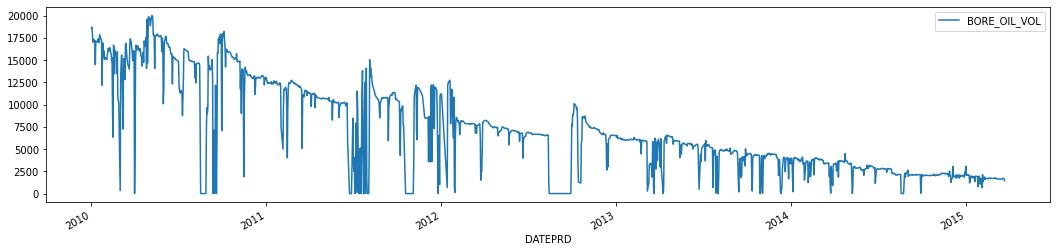

In [146]:
series.plot.line(figsize=(18,4))
plt.show()

**Multi-output forecasting strategy**

In [218]:
# convert series to stationary
series_diff =  series.diff()
# convert the stationary series to supervise learning
timesteps = 5
steps_ahead = 30
series_supervised = series_to_supervised(series_diff, series_diff.columns, n_in=timesteps, n_out=steps_ahead, dropnan=True)

In [219]:
pd.DataFrame(series_supervised)

,BORE_OIL_VOL(t-5),BORE_OIL_VOL(t-4),BORE_OIL_VOL(t-3),BORE_OIL_VOL(t-2),BORE_OIL_VOL(t-1),BORE_OIL_VOL(t),BORE_OIL_VOL(t+1),BORE_OIL_VOL(t+2),BORE_OIL_VOL(t+3),BORE_OIL_VOL(t+4),...,BORE_OIL_VOL(t+20),BORE_OIL_VOL(t+21),BORE_OIL_VOL(t+22),BORE_OIL_VOL(t+23),BORE_OIL_VOL(t+24),BORE_OIL_VOL(t+25),BORE_OIL_VOL(t+26),BORE_OIL_VOL(t+27),BORE_OIL_VOL(t+28),BORE_OIL_VOL(t+29)
DATEPRD,,,,,,,,,,,,,,,,,,,,,
2010-01-07,107.492863,-901.329859,-797.296392,268.323320,60.822469,-193.160084,-10.944270,-2649.834308,2671.659950,-76.232504,...,641.497783,-984.040868,242.220606,-64.910845,-70.571675,38.933928,-158.880616,533.438837,226.873468,526.394249
2010-01-08,-901.329859,-797.296392,268.323320,60.822469,-193.160084,-10.944270,-2649.834308,2671.659950,-76.232504,-16.416406,...,-984.040868,242.220606,-64.910845,-70.571675,38.933928,-158.880616,533.438837,226.873468,526.394249,-137.683954
2010-01-09,-797.296392,268.323320,60.822469,-193.160084,-10.944270,-2649.834308,2671.659950,-76.232504,-16.416406,10.315289,...,242.220606,-64.910845,-70.571675,38.933928,-158.880616,533.438837,226.873468,526.394249,-137.683954,-165.988102
2010-01-10,268.323320,60.822469,-193.160084,-10.944270,-2649.834308,2671.659950,-76.232504,-16.416406,10.315289,-20.253190,...,-64.910845,-70.571675,38.933928,-158.880616,533.438837,226.873468,526.394249,-137.683954,-165.988102,386.823352
2010-01-11,60.822469,-193.160084,-10.944270,-2649.834308,2671.659950,-76.232504,-16.416406,10.315289,-20.253190,330.277955,...,-70.571675,38.933928,-158.880616,533.438837,226.873468,526.394249,-137.683954,-165.988102,386.823352,-184.668839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02-18,24.907650,-7.421977,-5.094747,-1.886943,-56.734092,89.629801,19.938700,-40.946667,-37.613067,65.539826,...,-10.881372,-3.082007,-3.585192,-21.322458,9.623410,-14.026278,16.605100,18.806534,10.315289,3.270702
2015-02-19,-7.421977,-5.094747,-1.886943,-56.734092,89.629801,19.938700,-40.946667,-37.613067,65.539826,-2.578822,...,-3.082007,-3.585192,-21.322458,9.623410,-14.026278,16.605100,18.806534,10.315289,3.270702,44.783451
2015-02-20,-5.094747,-1.886943,-56.734092,89.629801,19.938700,-40.946667,-37.613067,65.539826,-2.578822,-37.613067,...,-3.585192,-21.322458,9.623410,-14.026278,16.605100,18.806534,10.315289,3.270702,44.783451,17.925960


In [220]:
# split into train and test sets
series_supervised = series_supervised.values
train_size = int(series_supervised.shape[0] * 0.8)
test_size = series_supervised.shape[0] - train_size
train, test = series_supervised[0:train_size], series_supervised[train_size:]
print(train.shape, test.shape)

(1447, 35) (362, 35)


In [221]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
print(train_scaled.shape, test_scaled.shape)

(1447, 35) (362, 35)


In [222]:
# reshape input to be 3D [samples, timesteps, features]
n_features = len(series.columns) 

train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
train_X = train_X.reshape(train_X.shape[0], timesteps, n_features)
test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
test_X = test_X.reshape(test_X.shape[0], timesteps, n_features )
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1447, 5, 1) (1447, 30) (362, 5, 1) (362, 30)


In [223]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.random.set_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

# fit the model
neurons= [4] 
n_epochs=18
batch_size=1

model = Sequential()
model.add(LSTM(neurons[0], batch_input_shape=(batch_size, timesteps, n_features), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(steps_ahead))
model.compile(loss='mean_squared_error', optimizer='adam')

# early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)
model.reset_states()

Epoch 1/18
1447/1447 - 6s - loss: 0.0401 - val_loss: 9.3281e-04 - 6s/epoch - 4ms/step
Epoch 2/18
1447/1447 - 4s - loss: 0.0072 - val_loss: 2.8948e-04 - 4s/epoch - 3ms/step
Epoch 3/18
1447/1447 - 4s - loss: 0.0055 - val_loss: 2.8185e-04 - 4s/epoch - 2ms/step
Epoch 4/18
1447/1447 - 4s - loss: 0.0054 - val_loss: 2.8105e-04 - 4s/epoch - 3ms/step
Epoch 5/18
1447/1447 - 4s - loss: 0.0053 - val_loss: 2.8091e-04 - 4s/epoch - 3ms/step
Epoch 6/18
1447/1447 - 5s - loss: 0.0053 - val_loss: 2.8076e-04 - 5s/epoch - 4ms/step
Epoch 7/18
1447/1447 - 4s - loss: 0.0053 - val_loss: 2.8061e-04 - 4s/epoch - 2ms/step
Epoch 8/18
1447/1447 - 4s - loss: 0.0053 - val_loss: 2.8062e-04 - 4s/epoch - 2ms/step
Epoch 9/18
1447/1447 - 3s - loss: 0.0053 - val_loss: 2.8052e-04 - 3s/epoch - 2ms/step
Epoch 10/18
1447/1447 - 4s - loss: 0.0053 - val_loss: 2.8043e-04 - 4s/epoch - 2ms/step
Epoch 11/18
1447/1447 - 4s - loss: 0.0053 - val_loss: 2.8023e-04 - 4s/epoch - 2ms/step
Epoch 12/18
1447/1447 - 4s - loss: 0.0053 - val_loss

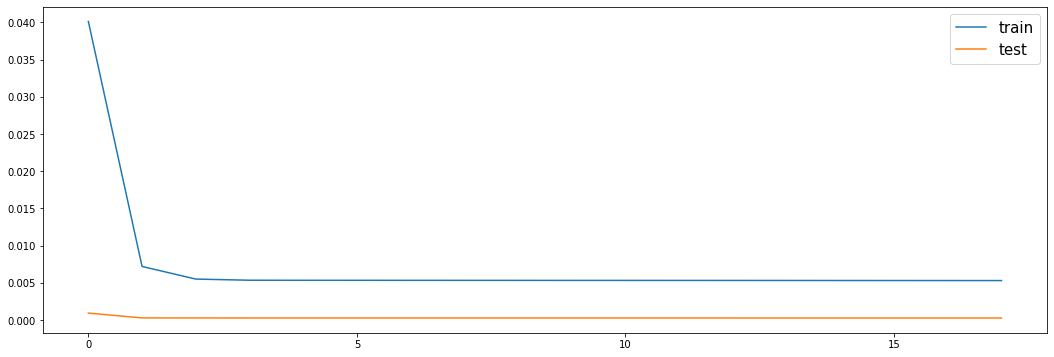

In [233]:
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(fontsize=15)
plt.show()

In [225]:
# make a prediction 
yhat = model.predict(test_X, batch_size)

# # invert scaling for actual
inv_y = inverse_transformation(series_supervised, -steps_ahead, test_y, new_max_range=1, new_min_range= 0)

# # #  Inverse of Differencing for actual 
cols = list()
df = pd.DataFrame(series.iloc[-len(test)-steps_ahead:,0])
for i in range(0, steps_ahead):
    cols.append(df.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
agg = agg.iloc[:-1]
agg = agg.to_numpy()
inv_y = np.add(inv_y,agg)

# # invert scaling for forecast
inv_yhat = inverse_transformation(series_supervised, -1, yhat, new_max_range=1, new_min_range= 0)

# #  Inverse of Differencing for forecast
inv_yhat = np.add(inv_yhat ,  agg)

# #return the same shape for another prediction trial
test_X = test_X.reshape((test_X.shape[0], timesteps, n_features))

362/362 [==============================] - 1s 2ms/step


In [238]:
# Performance evaluation
rmse_test, RMSPE_test, MAE_test, MAPE_test, r2_test, wMAPE_test, SMAPE_test  = [], [], [], [], [], [], []
for i in range(test_y.shape[1]):
    result_rmse = sqrt(mean_squared_error(inv_y[:,i], inv_yhat[:,i]))
    result_RMSPE = RMSPE(inv_y[:,i].flatten(), inv_yhat[:,i].flatten())
    result_MAE = mean_absolute_error(inv_y[:,i].flatten(), inv_yhat[:,i].flatten())
    result_MAPE = MAPE(inv_y[:,i].flatten(), inv_yhat[:,i].flatten())
    result_r2 = r2_score(inv_y[:,i].flatten(), inv_yhat[:,i].flatten())
    result_wMAPE = wMAPE(inv_y[:,i].flatten(), inv_yhat[:,i].flatten())
    result_SMAPE = SMAPE(inv_y[:,i].flatten(), inv_yhat[:,i].flatten())


    rmse_test.append(result_rmse)
    RMSPE_test.append(result_RMSPE)
    MAE_test.append(result_MAE)
    MAPE_test.append(result_MAPE)
    r2_test.append(result_r2)
    wMAPE_test.append(result_wMAPE)
    SMAPE_test.append(result_SMAPE)

print("The Average scores for the vector output {} steps ahead:\n".format(steps_ahead))
print('Test RMSE: %.5f' % np.mean(rmse_test))
#print('Test RMSPE: %.5f' % np.mean(RMSPE_test)) because of that the denominator (actual) has some zero values
print('Test MAE: %.5f' % np.mean(MAE_test))
#print('Test MAPE: %.5f' % np.mean(MAPE_test)) because of that the denominator (actual) has some zero values
print('Test r2: %.5f' % np.mean(r2_test))
print('Test wMAPE: %.5f ' % np.mean(wMAPE_test))
print('Test SMAPE: %.5f ' % np.mean(SMAPE_test))

The Average scores for the vector output 30 steps ahead:

Test RMSE: 482.93647
Test MAE: 212.76871
Test r2: 0.57017
Test wMAPE: 9.26372 
Test SMAPE: 15.78370 


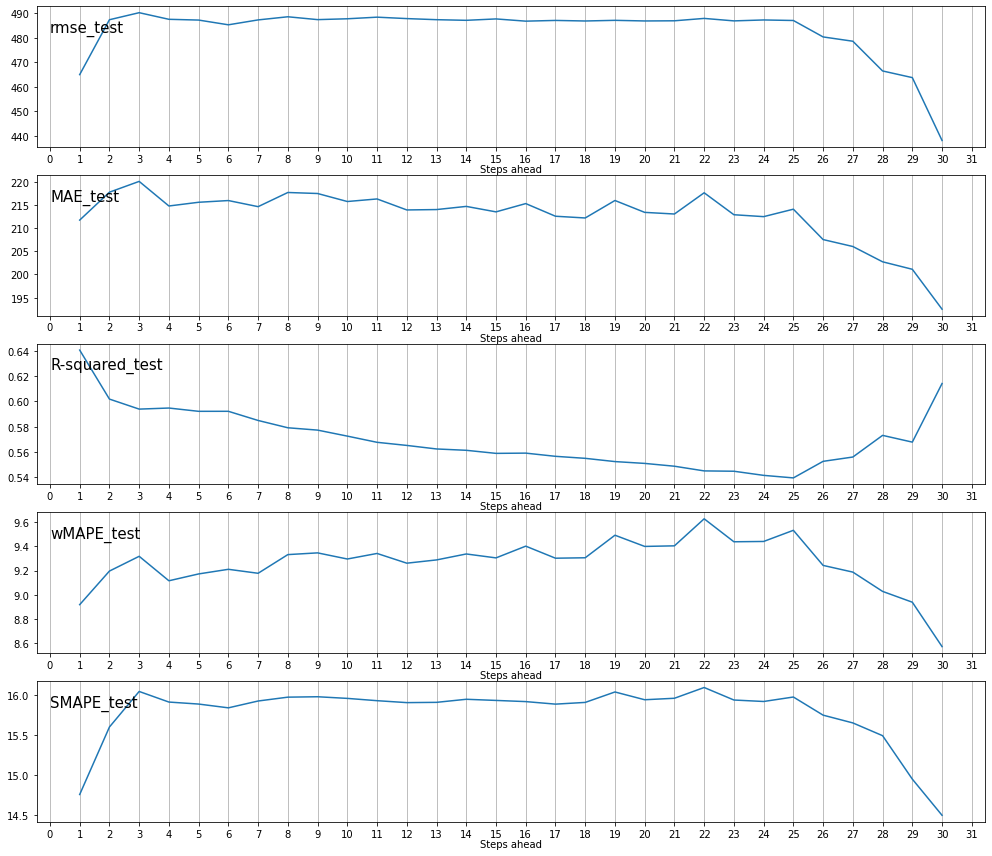

In [237]:
# plot the scores for each time step of the multi-step forecast
scores = pd.DataFrame({"rmse_test":rmse_test, "MAE_test":MAE_test, "R-squared_test":r2_test, "wMAPE_test":wMAPE_test, "SMAPE_test":SMAPE_test})

# Reset the index, keeping the old index as a column
scores = scores.reset_index(drop=False)

# Set the 'index' column as the new index
scores.index = scores['index'] + 1

# Drop the old 'index' column
scores = scores.drop(columns='index')

data = scores.columns

# Creating figure with two rows and one column
fig, axs = plt.subplots(nrows=len(data), figsize=(17, 15))

axs = axs.ravel()

for id, column in enumerate(data):
    # Set the x-axis limits
    #axs[id].set_xlim(xmin=1, xmax= steps_ahead)
    #print the name of the test on plot
    axs[id].plot(scores[column])
    # Add a title to the x-axis
    axs[id].set_xlabel('Steps ahead',fontsize=10, labelpad=0.1)
    axs[id].grid(True)
    # Remove the horizontal grid lines
    axs[id].grid(which='both', axis='y')
    axs[id].xaxis.set_major_locator(plt.MultipleLocator(1))
    axs[id].legend([column], loc='upper left', fontsize=15, handlelength=0, handletextpad=0, frameon=False)
    
plt.show()

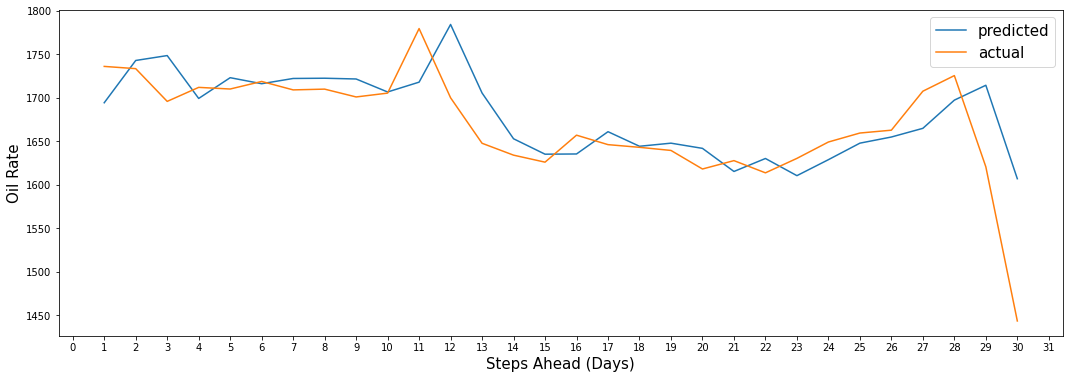

In [228]:
# plot the last forecasted values on test set
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
# Set the major locator for the x-axis
x = list(range(1, len(inv_yhat[-1])+1))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.plot(x, inv_yhat[-1], label = "predicted")
ax.plot(x, inv_y[-1], label = "actual")
ax.set_ylabel('Oil Rate', fontsize=15)
ax.set_xlabel('Steps Ahead (Days)',fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [229]:
#comparing predictions and actual values
act_pred = pd.DataFrame({"actual":inv_y.flatten(), "prediction":inv_yhat.flatten()})
act_pred.tail(20)

,actual,prediction
10840,1779.450317,1717.900872
10841,1699.947111,1784.173950
10842,1647.678785,1705.439298
10843,1634.029896,1652.857496
10844,1625.978938,1635.131458
10845,1656.987704,1635.381282
10846,1646.106332,1660.975986
10847,1643.024325,1644.232309
10848,1639.439133,1647.797762
10849,1618.116675,1641.831711
